In [77]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV,SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDRegressor
sns.set_theme()

# EDA

In [78]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [79]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [81]:
df.duplicated().values.any()

np.False_

In [82]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [83]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [84]:
def obtener_semana_mes(fecha):
    return min(int(np.ceil(fecha.day / 7)), 4)

In [85]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

In [86]:
df_copy.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

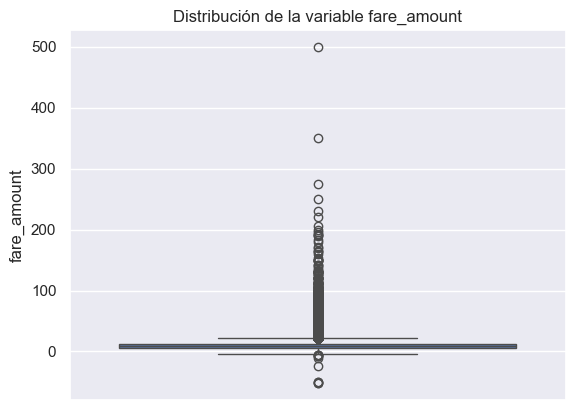

In [87]:
sns.boxplot(df_copy["fare_amount"])
plt.title("Distribución de la variable fare_amount");

A partir del gráfico y al observar la distribución de la variable se notaron dos casos:

* valores atípicos inferiores: en su mayoría valores negativos imposibles, menores a cero.
* valores atípicos superiores: se puede observar que las entradas con precios por encima de 200 son muy pocas en el dataset y se alejan en demasía de la mediana,  por esas razones se decide eliminar dichos registros.

In [88]:
# Filas con precios atípicos
df_copy[(df_copy["fare_amount"] > 200) | (df_copy["fare_amount"] < 0)]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.00,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3
23682,38390943,2014-11-02 22:40:20.0000004,206.38,2014-11-02 22:40:20 UTC,-73.782161,40.644601,-74.449079,40.836457,1
29261,5471406,2013-09-27 12:36:11.0000002,220.00,2013-09-27 12:36:11 UTC,-73.801147,40.671653,-73.790402,40.646742,1
63395,30260042,2015-03-03 23:07:41.0000008,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,51325304,2010-02-11 21:47:10.0000001,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
71715,38680012,2013-05-11 00:31:00.00000084,250.00,2013-05-11 00:31:00 UTC,0.000000,0.000000,0.000000,0.000000,1
79903,50284253,2015-05-01 14:43:02.0000004,-3.50,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1
89322,26673143,2010-03-09 08:26:10.0000006,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5
92063,10267585,2010-03-12 08:49:10.0000002,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3
98875,51135168,2015-03-20 21:31:14.0000007,-52.00,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5


Luego de ver los casos atípicos, se puede notar que poseen errores en las coordenadas de los mismos o coordenadas muy similares (distancias chicas).

In [89]:
len(df_copy[(df_copy["fare_amount"] > 200) | (df_copy["fare_amount"] < 0)])

24

Filtramos estos valores atipicos de nuestra columna target.

In [90]:
df_copy = df_copy[(df_copy["fare_amount"] < 200) & (df_copy["fare_amount"] > 0)] 

Se utilizan los siguientes gráficos para visualizar tendencias temporales.

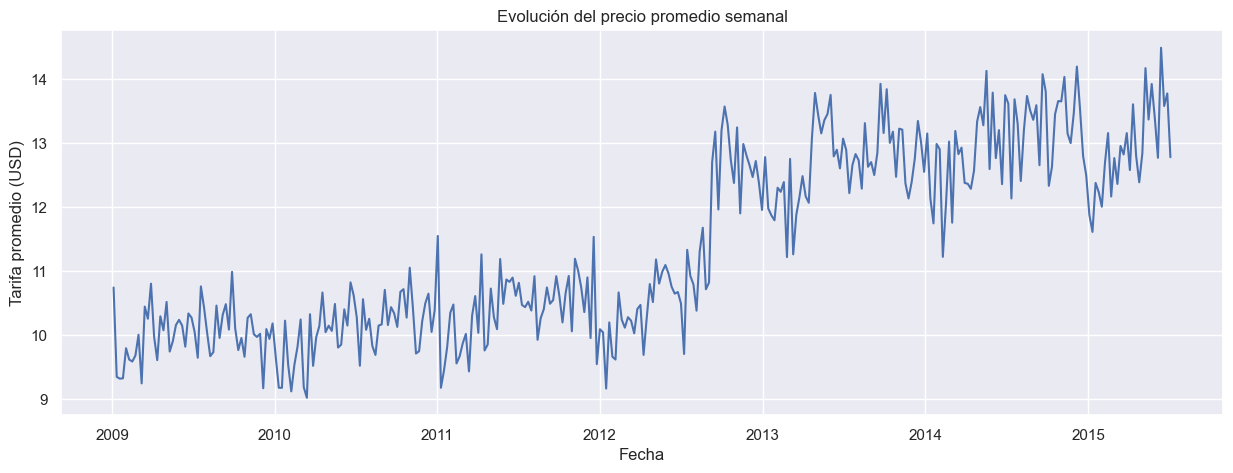

In [91]:
df['date'] = pd.to_datetime(df['date'])

promedio_semanal = df.resample('W', on='date')['fare_amount'].mean().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=promedio_semanal, x='date', y='fare_amount')
plt.title('Evolución del precio promedio semanal')
plt.xlabel('Fecha')
plt.ylabel('Tarifa promedio (USD)')
plt.show()

In [92]:
df_copy[df_copy["passenger_count"] > 7]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,35893772,2010-12-28 08:20:00.0000001,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


In [93]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]

Se observa que aproximadamente el 2% de las filas tienen mas de un valor faltante en las coordendas, lo que dificulta el cálculo de la distancia.

In [94]:
# Mas de 3 columnas de coordenadas con 0 lo filtramos
coords = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
conteo_ceros = (df_copy[coords] == 0.0).sum(axis=1)
pd.Series(conteo_ceros).value_counts()

0    196007
4      3583
2       359
1        20
Name: count, dtype: int64

Eliminación de filas con coordenadas faltantes

In [95]:
df_copy = df_copy[conteo_ceros == 0]

In [96]:
# Reseteo de índices para evitar conflictos.
df_copy.dropna(inplace=True)
df_copy.reset_index(drop=True, inplace=True) 

In [97]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196006 entries, 0 to 196005
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                196006 non-null  int64  
 1   date               196006 non-null  object 
 2   fare_amount        196006 non-null  float64
 3   pickup_datetime    196006 non-null  object 
 4   pickup_longitude   196006 non-null  float64
 5   pickup_latitude    196006 non-null  float64
 6   dropoff_longitude  196006 non-null  float64
 7   dropoff_latitude   196006 non-null  float64
 8   passenger_count    196006 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.5+ MB


# Ingenieria de caracteristicas

In [98]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [99]:
# Extraer el día de la semana de pickup_datetime
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [100]:
# Extraer la hora del pickup_datetime
df_copy['hora'] = df_copy['pickup_datetime'].dt.hour

# Aplicar transformación trigonométrica para la hora (ciclo de 24 horas)
n = 24
df_copy["hora_sin"] = np.sin(2 * np.pi * df_copy["hora"] / n)
df_copy["hora_cos"] = np.cos(2 * np.pi * df_copy["hora"] / n)


In [101]:
df_copy.drop(columns=["dia_semana","hora"], inplace=True) #eliminación de columnas que ya no serán utilizadas

In [102]:
# Cálculo de distancia en kilómetros a partir de las coordendas.
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [103]:
# Eliminación de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [104]:
# Cálculo de columna semana_mes.
df_copy["semana_mes"] = df_copy["pickup_datetime"].apply(obtener_semana_mes)

In [105]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,-0.965926,0.258819,1.683323,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,-0.866025,0.500000,2.457590,3
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,-0.707107,0.707107,5.036377,4
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,4
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,-0.965926,-0.258819,4.475450,4


El gráfico muestra una distribución desigual en la cantidad de viajes a lo largo de las semanas del mes. Se observa un aumento notable en la cuarta semana, que concentra la mayor cantidad de viajes, mientras que la primera semana presenta el menor volumen. Esta variabilidad sugiere la presencia de patrones temporales dentro del mes, lo que justifica incluir la variable semana_mes en el modelo para capturar posibles efectos en la demanda de viajes.

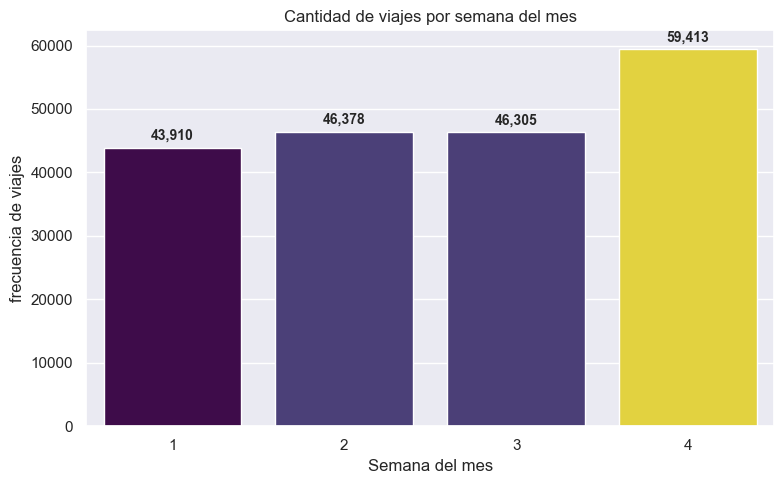

In [106]:
semana_counts = df_copy["semana_mes"].value_counts().sort_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=semana_counts.index, y=semana_counts.values, palette="viridis", hue=semana_counts, legend=False)

for i, v in enumerate(semana_counts.values):
    ax.text(i, v + 800, f"{v:,}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Cantidad de viajes por semana del mes")
plt.xlabel("Semana del mes")
plt.ylabel("frecuencia de viajes")
plt.tight_layout()
plt.show()


El gráfico muestra que el precio promedio de los viajes se mantiene relativamente estable entre las semanas del mes, con leves variaciones.

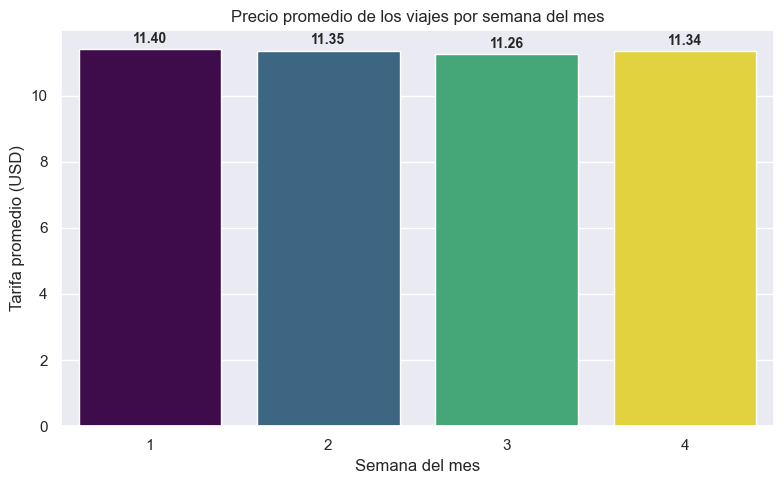

In [107]:
precio_promedio = df_copy.groupby("semana_mes")["fare_amount"].mean().reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(data=precio_promedio, x="semana_mes", y="fare_amount", palette="viridis",hue="semana_mes",legend=False)

for i, v in enumerate(precio_promedio["fare_amount"]):
    ax.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Precio promedio de los viajes por semana del mes")
plt.xlabel("Semana del mes")
plt.ylabel("Tarifa promedio (USD)")
plt.tight_layout()
plt.show()

In [108]:
# Eliminación de columnas que no se utilizarán. 
coords = ["key","pickup_datetime" ,"pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
df_copy.drop(columns=coords, inplace=True)

In [109]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196006 entries, 0 to 196005
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      196006 non-null  float64
 1   passenger_count  196006 non-null  Int64  
 2   dia_sin          196006 non-null  float64
 3   dia_cos          196006 non-null  float64
 4   hora_sin         196006 non-null  float64
 5   hora_cos         196006 non-null  float64
 6   distance_km      196006 non-null  float64
 7   semana_mes       196006 non-null  int64  
dtypes: Int64(1), float64(6), int64(1)
memory usage: 12.2 MB


In [110]:
# Creación de dummies en columnas categóricas.
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['semana_mes', 'passenger_count']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['semana_mes', 'passenger_count']))

df_encoded = pd.concat([df_copy.drop(columns=['semana_mes', 'passenger_count']), encoded_df], axis=1)

df_encoded.head()


,fare_amount,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
0,7.5,0.433884,-0.900969,-0.965926,0.258819,1.683323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.7,-0.433884,-0.900969,-0.866025,0.500000,2.457590,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,12.9,0.000000,1.000000,-0.707107,0.707107,5.036377,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.3,-0.433884,-0.900969,0.866025,-0.500000,1.661683,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,16.0,0.433884,-0.900969,-0.965926,-0.258819,4.475450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
cols_dummies = [c for c in df_encoded.columns if c.startswith("semana_mes_") or c.startswith("passenger_count_")]
df_encoded[cols_dummies] = df_encoded[cols_dummies].astype('Int32')

In [112]:
not_dummy_cols = ["fare_amount","dia_sin","dia_cos","hora_sin","hora_cos","distance_km"]
df_encoded[not_dummy_cols] = df_encoded[not_dummy_cols].astype("float32")

In [113]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196006 entries, 0 to 196005
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fare_amount          196006 non-null  float32
 1   dia_sin              196006 non-null  float32
 2   dia_cos              196006 non-null  float32
 3   hora_sin             196006 non-null  float32
 4   hora_cos             196006 non-null  float32
 5   distance_km          196006 non-null  float32
 6   semana_mes_2         196006 non-null  Int32  
 7   semana_mes_3         196006 non-null  Int32  
 8   semana_mes_4         196006 non-null  Int32  
 9   passenger_count_1.0  196006 non-null  Int32  
 10  passenger_count_2.0  196006 non-null  Int32  
 11  passenger_count_3.0  196006 non-null  Int32  
 12  passenger_count_4.0  196006 non-null  Int32  
 13  passenger_count_5.0  196006 non-null  Int32  
 14  passenger_count_6.0  196006 non-null  Int32  
dtypes: Int32(9), floa

El correlograma muestra que no hay correlaciones fuertes entre las variables. La única relación algo destacable es entre hora_sin y hora_cos, esperable por representar la misma variable temporal transformada. La distance_km tiene una correlación muy débil y positiva con fare_amount, lo que indica una relación poco lineal entre distancia y precio.


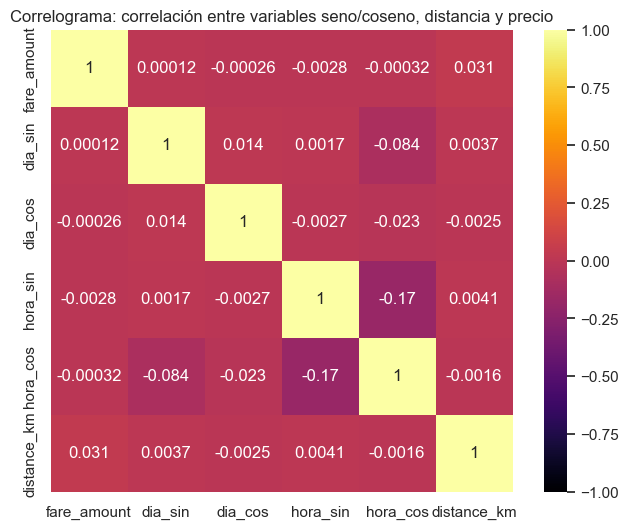

In [114]:
plt.figure(figsize=(8,6))
sns.heatmap(df_encoded[['fare_amount', 'dia_sin', 'dia_cos', 'hora_sin', 'hora_cos', 'distance_km']].corr(), annot=True, cmap='inferno', square=True, vmax=1, vmin=-1)
plt.title("Correlograma: correlación entre variables seno/coseno, distancia y precio", fontsize=12)
plt.show()


# Modelo de regresion

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156804 entries, 72653 to 121958
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dia_sin              156804 non-null  float32
 1   dia_cos              156804 non-null  float32
 2   hora_sin             156804 non-null  float32
 3   hora_cos             156804 non-null  float32
 4   distance_km          156804 non-null  float32
 5   semana_mes_2         156804 non-null  Int32  
 6   semana_mes_3         156804 non-null  Int32  
 7   semana_mes_4         156804 non-null  Int32  
 8   passenger_count_1.0  156804 non-null  Int32  
 9   passenger_count_2.0  156804 non-null  Int32  
 10  passenger_count_3.0  156804 non-null  Int32  
 11  passenger_count_4.0  156804 non-null  Int32  
 12  passenger_count_5.0  156804 non-null  Int32  
 13  passenger_count_6.0  156804 non-null  Int32  
dtypes: Int32(9), float32(5)
memory usage: 10.9 MB


Se observan en el dataset de train 1606 valores cuya distancia es 0.  

In [117]:
X_train[X_train["distance_km"] == 0]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
17481,0.974928,-0.222521,7.071068e-01,-0.707107,0.0,0,0,1,1,0,0,0,0,0
27864,-0.974928,-0.222521,-8.660254e-01,0.500000,0.0,0,0,1,1,0,0,0,0,0
75444,-0.433884,-0.900969,7.071068e-01,-0.707107,0.0,0,0,1,0,0,1,0,0,0
190576,0.781832,0.623490,-5.000000e-01,-0.866025,0.0,0,1,0,1,0,0,0,0,0
17207,0.000000,1.000000,1.224647e-16,-1.000000,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,-0.433884,-0.900969,-5.000000e-01,0.866025,0.0,1,0,0,0,0,0,0,0,1
166267,-0.781832,0.623490,-5.000000e-01,0.866025,0.0,0,0,1,1,0,0,0,0,0
83613,0.781832,0.623490,-7.071068e-01,0.707107,0.0,0,0,1,1,0,0,0,0,0
87922,-0.433884,-0.900969,5.000000e-01,-0.866025,0.0,0,1,0,1,0,0,0,0,0


2562 filas contienen valores más chicos que la distancia recorrida en una cuadra. 

In [118]:
X_train[X_train["distance_km"] < 0.1]

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
17481,0.974928,-0.222521,0.707107,-7.071068e-01,0.000000,0,0,1,1,0,0,0,0,0
41903,0.974928,-0.222521,-0.707107,7.071068e-01,0.000084,0,0,1,1,0,0,0,0,0
153451,0.433884,-0.900969,0.965926,-2.588190e-01,0.012473,0,0,1,1,0,0,0,0,0
151661,-0.433884,-0.900969,-0.866025,-5.000000e-01,0.026987,0,0,1,1,0,0,0,0,0
27864,-0.974928,-0.222521,-0.866025,5.000000e-01,0.000000,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133272,0.974928,-0.222521,-0.258819,-9.659258e-01,0.000000,0,1,0,1,0,0,0,0,0
96601,-0.781832,0.623490,0.500000,-8.660254e-01,0.001560,0,1,0,1,0,0,0,0,0
90084,0.781832,0.623490,-1.000000,-1.836970e-16,0.010957,0,0,1,1,0,0,0,0,0
64044,0.000000,1.000000,0.500000,-8.660254e-01,0.022474,0,0,0,0,0,0,1,0,0


In [119]:
# Muy pocos viajes en los nuevos dataset con distancias mayores a 60
X_train[X_train["distance_km"] > 90].shape[0], X_test[X_test["distance_km"] > 90].shape[0]

(83, 26)

In [120]:
X_train[X_train["distance_km"] < 0.1].shape[0], X_test[X_test["distance_km"] < 0.1].shape[0]

(2562, 651)

En base a lo observado anteriormente, se toma la conclusión de realizar un trabajo de imputación sobre aquellas distancias que sean menores a 0.1 (en su mayoría celdas con valor 0 en ese atributo) y mayores a 90 km. Teniendo en cuenta que ir de norte a sur en la ciudad de Nueva York implicaría [recorrer 35 millas](https://www.takewalks.com/blog/nyc-by-the-numbers#:~:text=The%20total%20area%20of%20the,southwest%2C%20is%20about%2035%20miles) (aproximadamente 60 km). Por lo tanto, manteniendo hasta una distancia de noventa, se cubren casos en los que un pasajero toma un viaje desde una punta de la ciudad a la otra y va hacia un lugar en las cercanías.

In [121]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 90) | (X_train["distance_km"] < 0.1), "distance_km"] = np.nan

In [122]:
X_test.loc[(X_test["distance_km"] > 90) | (X_test["distance_km"] < 0.1), "distance_km"] = np.nan

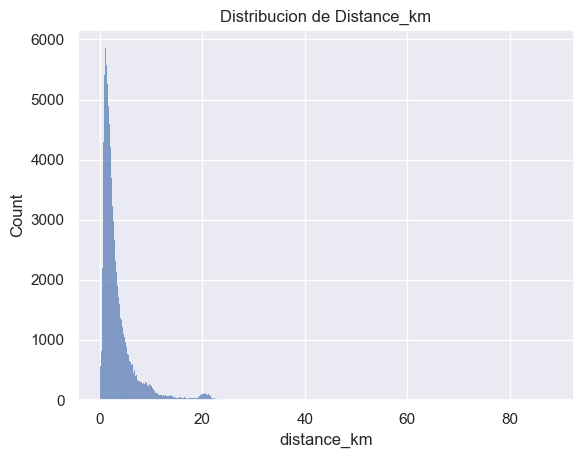

In [123]:
# Observamos la distribución de distance antes de realizar la imputación.
sns.histplot(X_train["distance_km"])
plt.title('Distribucion de Distance_km')
plt.show()

In [124]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,156804.000000,156804.000000,156804.000000,156804.000000,154159.000000,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0
mean,-0.002527,-0.044347,-0.194708,-0.068447,3.364865,0.237022,0.236359,0.302677,0.691825,0.147394,0.044195,0.021173,0.070241,0.021753
std,0.711470,0.701316,0.668873,0.714156,3.598838,0.425257,0.424846,0.459418,0.461741,0.3545,0.205529,0.143961,0.255553,0.145877
min,-0.974928,-0.900969,-1.000000,-1.000000,0.100227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,1.293430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,2.193798,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,3.946942,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,88.129547,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [125]:
cols = ['distance_km']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
X_test_scaled[cols] = scaler.transform(X_test[cols])

In [126]:
# Todas las columnas numéricas
cols_to_impute = X_train.columns  

# Instanciar imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Fit en train, transform en train y test
X_train_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train_scaled[cols_to_impute]),
    columns=cols_to_impute,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    knn_imputer.transform(X_test_scaled[cols_to_impute]),
    columns=cols_to_impute,
    index=X_test.index
)


X_train_scaled["distance_km"] = X_train_imputed["distance_km"]
X_test_scaled["distance_km"] = X_test_imputed["distance_km"]

In [127]:
X_train_scaled.describe()

,dia_sin,dia_cos,hora_sin,hora_cos,distance_km,semana_mes_2,semana_mes_3,semana_mes_4,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
count,156804.000000,156804.000000,156804.000000,156804.000000,156804.000000,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0,156804.0
mean,-0.002527,-0.044347,-0.194708,-0.068447,-0.000008,0.237022,0.236359,0.302677,0.691825,0.147394,0.044195,0.021173,0.070241,0.021753
std,0.711470,0.701316,0.668873,0.714156,0.993373,0.425257,0.424846,0.459418,0.461741,0.3545,0.205529,0.143961,0.255553,0.145877
min,-0.974928,-0.900969,-1.000000,-1.000000,-0.907140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.781832,-0.900969,-0.866025,-0.707107,-0.572142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,-0.222521,-0.258819,-0.258819,-0.320382,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,0.781832,0.623490,0.500000,0.707107,0.162810,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
max,0.974928,1.000000,1.000000,1.000000,23.553427,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


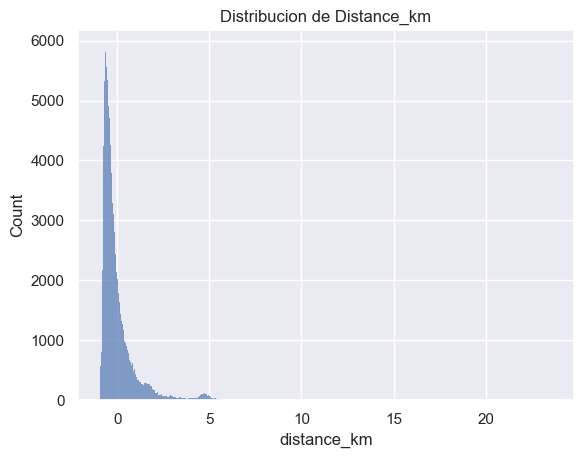

In [128]:
# Observamos la distribución de distance luego de realizar la imputación.
sns.histplot(X_train_scaled["distance_km"])
plt.title('Distribucion de Distance_km')
plt.show()

In [129]:
# crear un pipeline para la preprocesamiento y el modelo
pipeline = Pipeline([ 
    ('Linear', LinearRegression())  
])

# ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train_scaled, y_train)

# hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test_scaled)

El modelo explica un *76% de la variación* de los datos. 

In [130]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 2.41
RMSE: 4.84
R²: 0.76


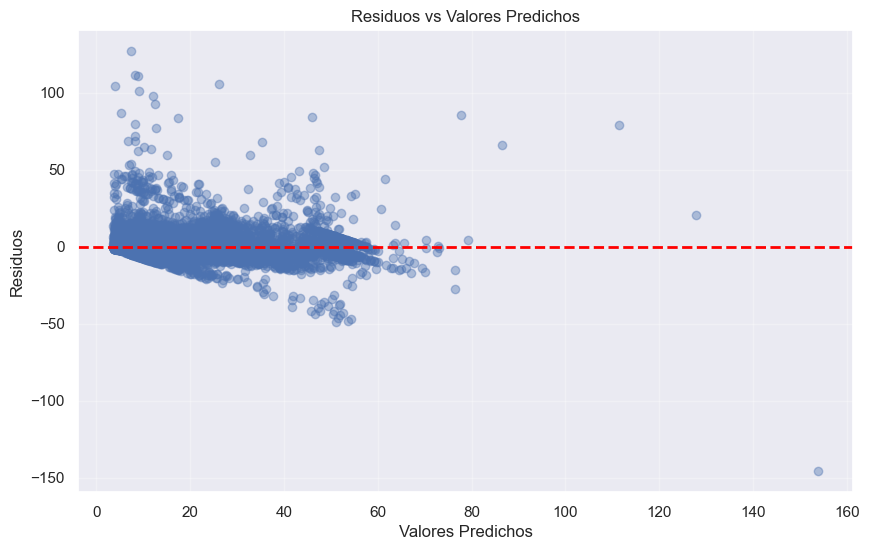

In [131]:
residuos = y_test - y_pred

# Crear gráfico de residuos
plt.figure(figsize=(10, 6))

# Gráfico 1: Residuos vs Valores Predichos
plt.scatter(y_pred, residuos, alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

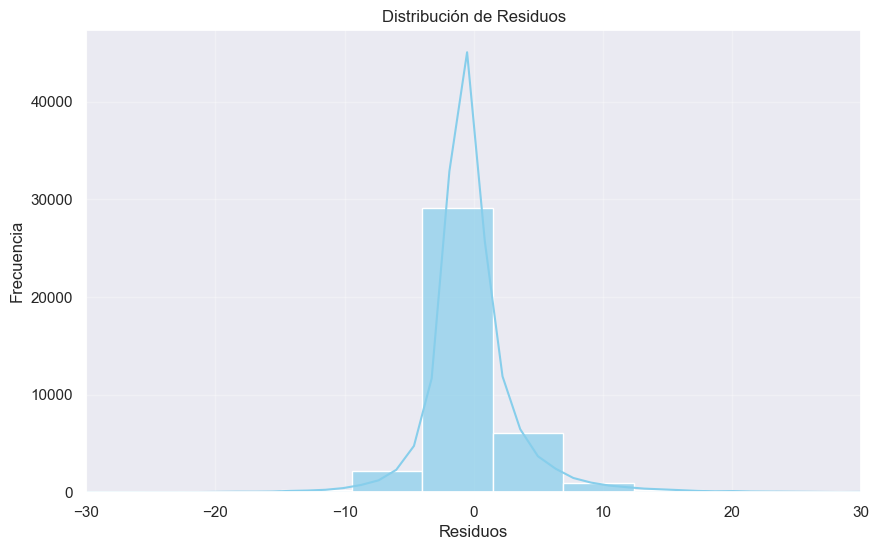

In [132]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=50, color='skyblue', alpha=0.7, kde=True)
plt.xlim(-30, 30)  # Ajusta según tus datos
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

Los residuos observados anteriormente presentan una distribución normal, lo que permite ver que el modelo no parece predecir de manera sesgada. La mayoría de las predicciones del modelo se concentran en el rango entre 1 dolar a 60 dolares aproximadamente, lo cual es coherente con lo esperado luego del trabajo realizado sobre las distancias.   

Visualización de coeficientes.

In [133]:
regressor = pipeline.named_steps['Linear']

# Obtener coeficientes
coefs = regressor.coef_

# Crear DataFrame que relacione variable con su coeficiente
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': coefs
})

print(coef_df)

               Variable  Coeficiente
0               dia_sin    -0.017464
1               dia_cos     0.004447
2              hora_sin    -0.042934
3              hora_cos    -0.022495
4           distance_km     8.435361
5          semana_mes_2    -0.023623
6          semana_mes_3    -0.004476
7          semana_mes_4     0.008219
8   passenger_count_1.0     1.110214
9   passenger_count_2.0     1.188441
10  passenger_count_3.0     1.196918
11  passenger_count_4.0     1.317036
12  passenger_count_5.0     1.004678
13  passenger_count_6.0     1.795220


# Gradiente 

In [134]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W



In [135]:
# Escalado para correcto funcionamiento de GD
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

Época 10/100, Train MSE: 24.1984, Test MSE: 24.3581
Época 20/100, Train MSE: 23.7781, Test MSE: 23.9424
Época 30/100, Train MSE: 23.6130, Test MSE: 23.7784
Época 40/100, Train MSE: 23.5167, Test MSE: 23.6821
Época 50/100, Train MSE: 23.4521, Test MSE: 23.6172
Época 60/100, Train MSE: 23.4060, Test MSE: 23.5705
Época 70/100, Train MSE: 23.3720, Test MSE: 23.5359
Época 80/100, Train MSE: 23.3463, Test MSE: 23.5096
Época 90/100, Train MSE: 23.3265, Test MSE: 23.4892
Época 100/100, Train MSE: 23.3111, Test MSE: 23.4732


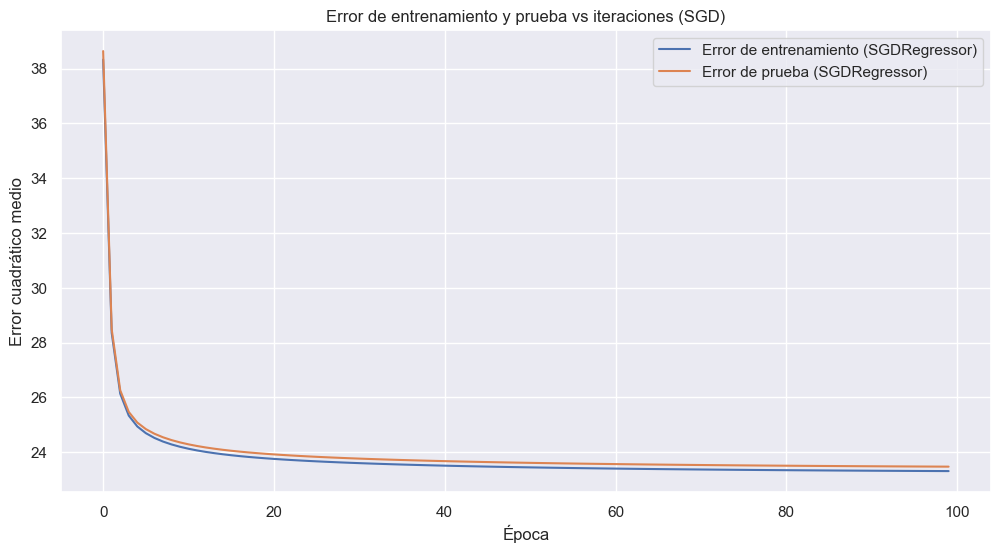

Época 10/50, Train MSE: 24.2009, Test MSE: 24.3599
Época 20/50, Train MSE: 23.7781, Test MSE: 23.9420
Época 30/50, Train MSE: 23.6128, Test MSE: 23.7776
Época 40/50, Train MSE: 23.5165, Test MSE: 23.6816
Época 50/50, Train MSE: 23.4519, Test MSE: 23.6165


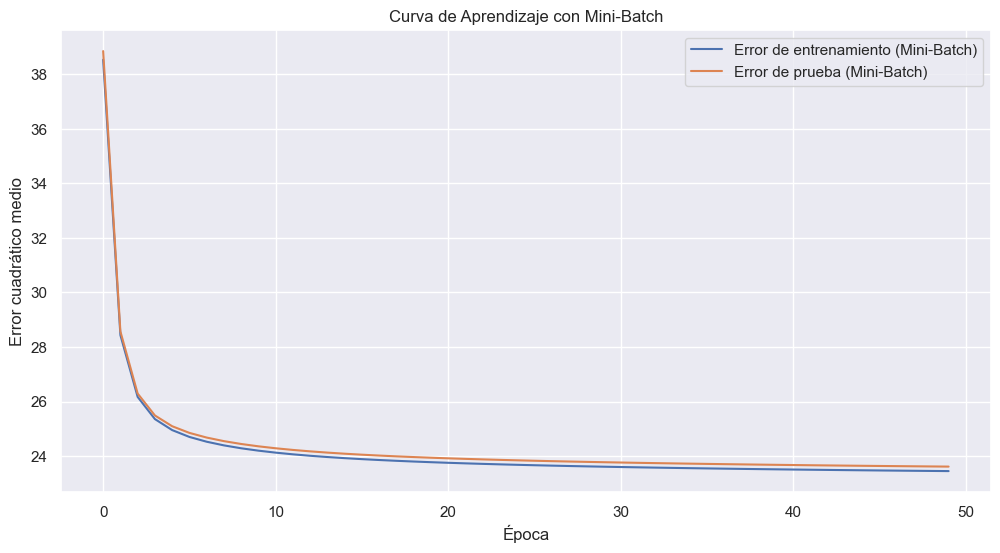

In [136]:
# Codigo sgd y minibatch

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()


# SGD

warm_start=True 
max_iter=1 
sgd = SGDRegressor(
    max_iter=1,
    tol=None,
    penalty=None,  
    learning_rate='invscaling',  # Tasa de aprendizaje constante
    eta0=0.0001,  # lr
    warm_start=True, 
    random_state=42 
)


epochs = 100
train_errors = []
test_errors = []

for epoch in range(epochs):
    # Entrenamiento parcial
    sgd.partial_fit(X_train_scaled, y_train_flat)

    y_train_pred = sgd.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
      print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (SGDRegressor)')
plt.plot(range(epochs), test_errors, label='Error de prueba (SGDRegressor)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
plt.grid(True)
plt.show()



X_train_scaled_array = X_train_scaled.values  
X_test_scaled_array = X_test_scaled.values


sgd = SGDRegressor(
    max_iter=1,  
    tol=None,
    penalty=None,
    learning_rate='invscaling',
    eta0=0.0001,  
    warm_start=True, 
    random_state=42
)


epochs = 50
batch_size = 100 
n_samples = X_train_scaled_array.shape[0]

train_errors = []
test_errors = []


for epoch in range(epochs):


    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train_scaled_array[permutation]
    y_train_shuffled = y_train_flat[permutation]


    for j in range(0, n_samples, batch_size):
        # Tomar un lote
        x_batch = X_train_shuffled[j:j + batch_size]
        y_batch = y_train_shuffled[j:j + batch_size]

        sgd.partial_fit(x_batch, y_batch)

    # Después de pasar por todos los lotes (una época completa), medir el error
    y_train_pred = sgd.predict(X_train_scaled_array)
    train_mse = mean_squared_error(y_train_flat, y_train_pred)
    train_errors.append(train_mse)

    y_test_pred = sgd.predict(X_test_scaled_array)
    test_mse = mean_squared_error(y_test_flat, y_test_pred)
    test_errors.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{epochs}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_errors, label='Error de entrenamiento (Mini-Batch)')
plt.plot(range(epochs), test_errors, label='Error de prueba (Mini-Batch)')
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.title('Curva de Aprendizaje con Mini-Batch')
plt.grid(True)
plt.show()

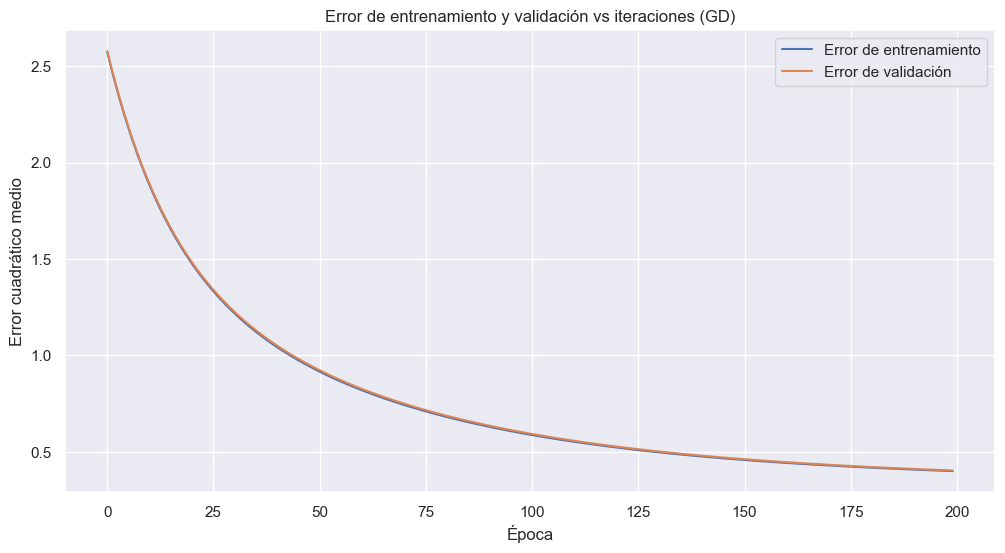

array([[-0.4037460470600506],
       [0.08457515566841248],
       [0.07493247478204056],
       [-0.22038089618689988],
       [-0.023888711959671887],
       [0.8741431874097776],
       [0.4110004011414759],
       [0.5132433607141763],
       [0.6802713647431542],
       [-0.10050213864311999],
       [-0.056392698285229435],
       [-0.8429961753248102],
       [0.6441804074982994],
       [-0.1194378191412495],
       [1.0413027762174958]], dtype=object)

In [137]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=200)

Se observa una convergencia del modelo un poco más brusca tanto en minibatch como con SGD, mientras que la evolución de pérdida en GD es más suave.  

# Regularización

## Ridge

Se prueba una amplia gama de valores de alpha para encontrar el óptimo y observar el comportamiento de los coeficientes.

In [138]:
model_ridge = make_pipeline(RidgeCV(alphas = np.logspace(-3, 9, 200),
                              fit_intercept   = True,
                              store_cv_results = True
                        )
         )

model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_test_scaled)
r2_ridge = r2_score(y_test,y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test,y_pred_ridge))
alpha_optimo = model_ridge.named_steps['ridgecv'].alpha_
print(f"Alpha optimo: {alpha_optimo}.")
print(f"R2: {r2_ridge}.")
print(f"RMSE: {rmse_ridge}.")

Alpha optimo: 1.1895340673703196.
R2: 0.7551076311623601.
RMSE: 4.836822714184289.


In [139]:
# Para evitar conflicos de tipo de dato en la resta para obsevar residuos lo pasamos como DF
y_pred_ridge = pd.DataFrame(y_pred_ridge)

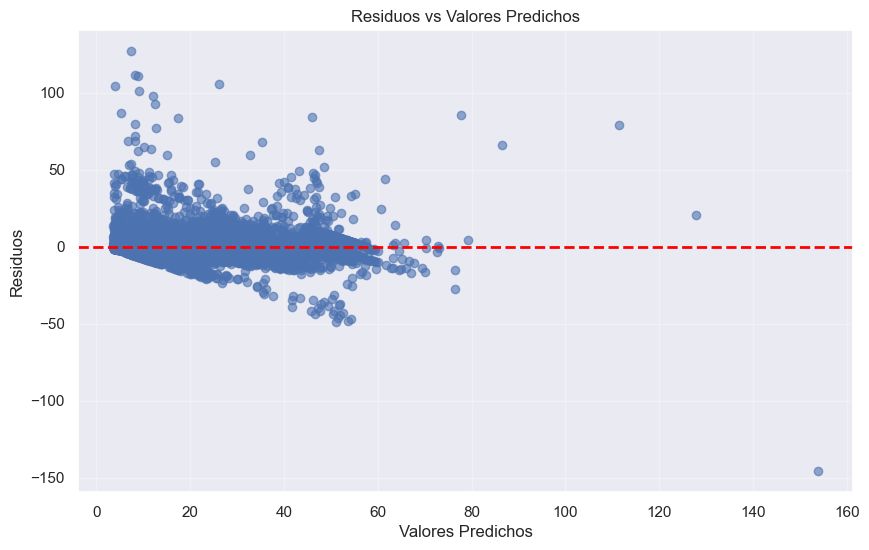

In [140]:
residuos_ridge = y_test - y_pred_ridge

# Gráfico 1: Residuos vs Valores Predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, residuos_ridge, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

Los residuos del modelo son iguales a los observados en la regresión con el método de OLS. El gráfico de abajo resalta la relevancia que tiene en la regresión la variable *distance_km*, requiriendo la misma un alpha de tamaño considerable para que su coeficiente tienda a 0. Todos los otros coeficientes empiezan a desaparecer con un alpha igual a 100.

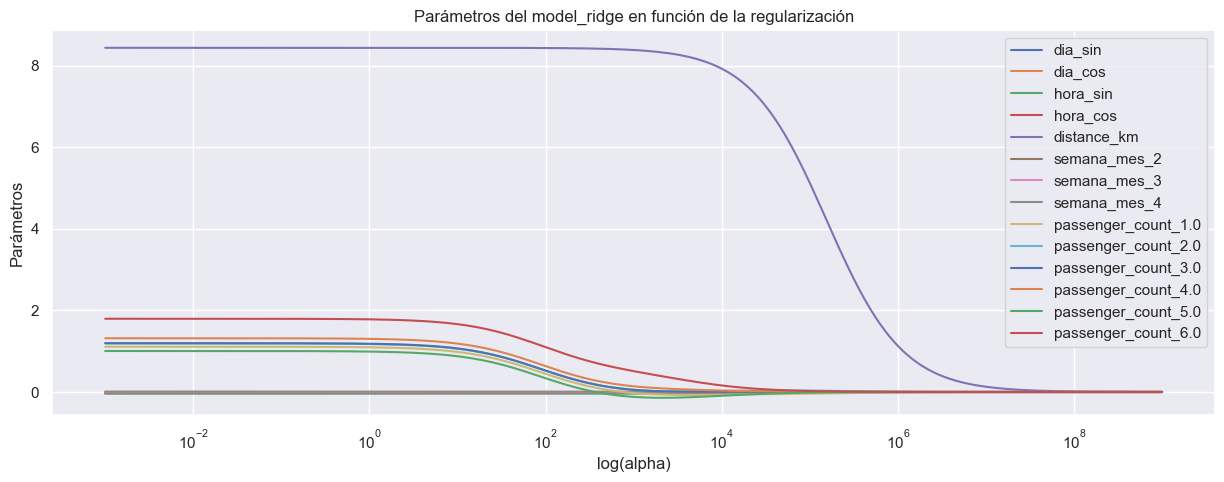

In [143]:
# Evolución de los parámetros en función de alpha

alphas = model_ridge.steps[0][1].alphas
coefs = []

for alpha in alphas:
    model_ridge_aux = make_pipeline(Ridge(alpha=alpha))
    model_ridge_aux.fit(X_train_scaled, y_train)
    coefs.append(model_ridge_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del model_ridge en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

## Lasso

In [144]:
model_lasso = make_pipeline(LassoCV(alphas = np.logspace(-3, 3, 200),
                              fit_intercept = True,
                              cv = 5
                        )
         )

model_lasso.fit(X_train_scaled, y_train)

y_pred_lasso= model_lasso.predict(X_test_scaled)
r2_lasso= r2_score(y_test,y_pred_lasso)
rmse_lasso= np.sqrt(mean_squared_error(y_test,y_pred_lasso))
alpha_optimo_lasso = model_lasso.named_steps['lassocv'].alpha_
print(f"RMSE:{rmse_lasso}.")
print(f"R2:{r2_lasso}.")
print(f"Alpha óptimo: {alpha_optimo_lasso}.")

c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE:4.837416165141771.
R2:0.7550475336417187.
Alpha óptimo: 0.001.


In [145]:
# Para evitar conflicos de tipo de dato en la resta para obsevar residuos lo pasamos como DF
y_pred_lasso = pd.DataFrame(y_pred_lasso)

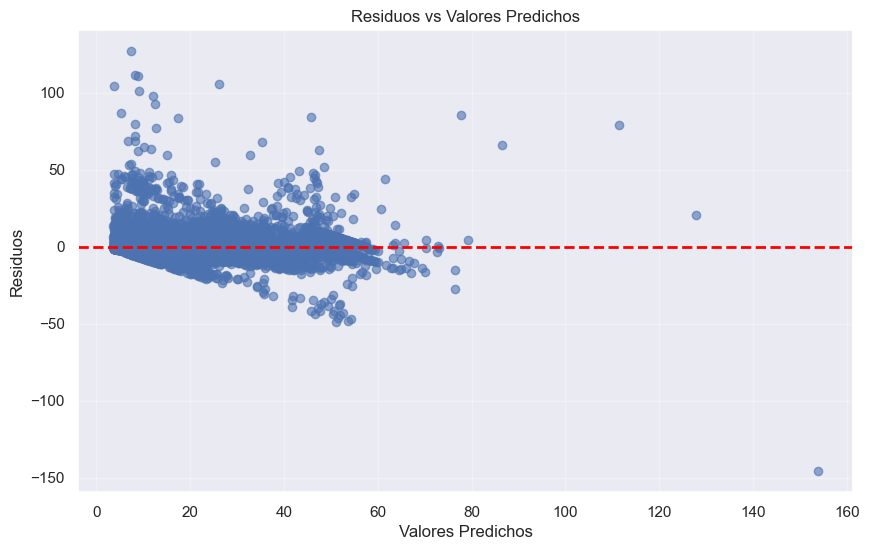

In [146]:
residuos_lasso = y_test - y_pred_lasso

# Residuos vs Valores Predichos - lasso
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lasso, residuos_lasso, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.grid(True, alpha=0.3)

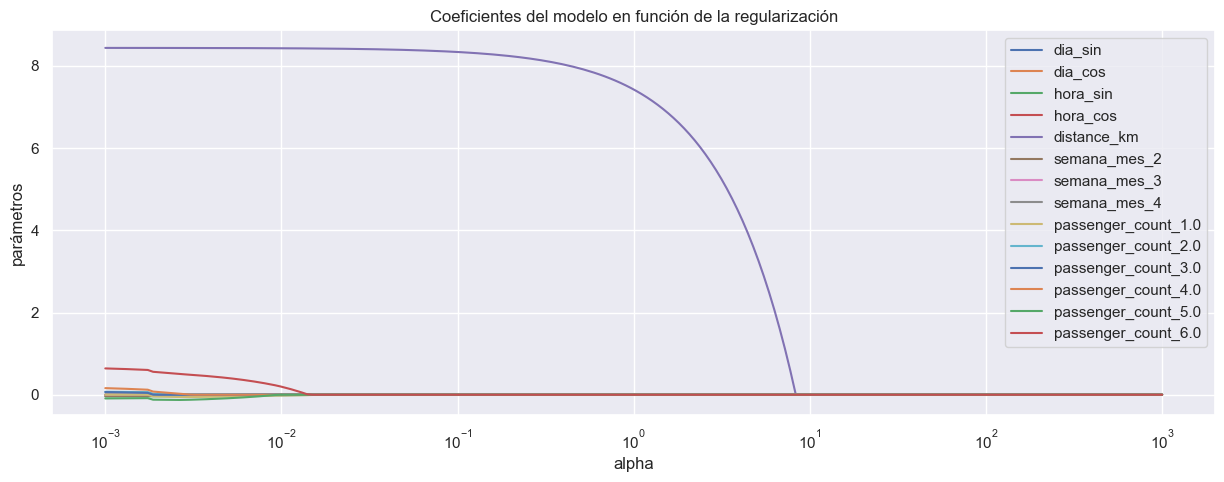

In [147]:
# Evolución de los parámetros en función de alpha

mod = model_lasso.steps[0][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    model_lasso_aux = make_pipeline(Lasso(alpha=alpha))
    model_lasso_aux.fit(X_train_scaled, y_train)
    coefs.append(model_lasso_aux.steps[0][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train_scaled.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Los residuos de lasso muestran el mismo comportamiento que los modelos previos. El gráfico muestra la agresividad con la que lasso lleva a 0 el valor de los coeficientes pequeños a diferencia de Ridge, necesitando un alpha cercano a 10 a la -2 para llevar todos los coeficientes a 0 menos la distancia. 

## ElasticNet

In [148]:
model_elastic = make_pipeline(ElasticNetCV(
                              l1_ratio= [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas = np.logspace(-3, 4, 200),
                              cv = 5
                           )
         )

_ = model_elastic.fit(X_train_scaled, y_train)

mod = model_elastic.steps[0][1]

c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.900e+06, tolerance: 1.180e+03
  model = cd_fast.enet_coordin

In [149]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
rmse_elastic_net = df_resultados_cv['rmse_cv'].min()
df_resultados_cv

,l1_ratio,mod.alphas_,mse_cv,rmse_cv
199,0.0,0.001000,23.250269,4.821853
198,0.0,0.001084,23.250408,4.821868
399,0.1,0.001000,23.250436,4.821871
197,0.0,0.001176,23.250549,4.821882
398,0.1,0.001084,23.250592,4.821887
...,...,...,...,...
679,0.7,16.638169,93.497760,9.669424
680,0.7,15.343684,93.497760,9.669424
681,0.7,14.149913,93.497760,9.669424
682,0.7,13.049020,93.497760,9.669424


Se puede observar que el mejor rmse se obtiene dejando un 0.0 de Lasso en el modelo de Elastic-Net. Esto ocurre porque, al haber coeficientes chicos de algunas variables, Ridge hace que sus valores tiendan a 0 demasiado rápido, haciendo que el modelo quede cuente con menos información.  

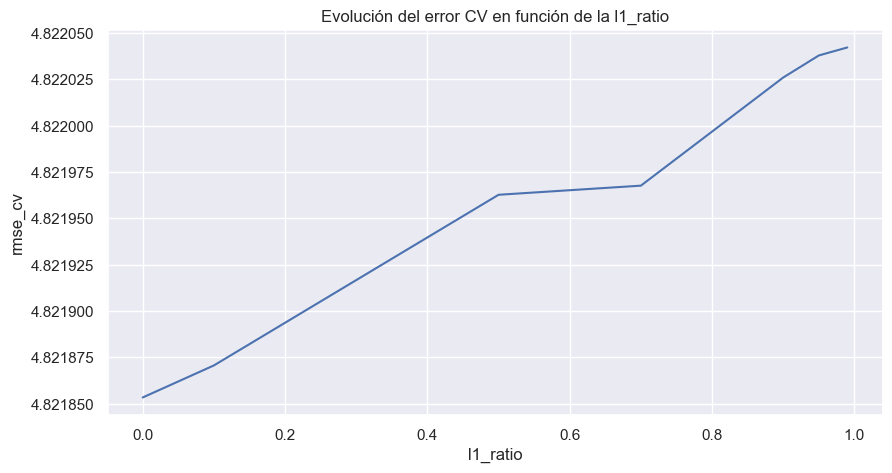

In [150]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [151]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.001
Mejor valor de l1_ratio encontrado: 0.0


In [152]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': mod.coef_.flatten()}
                  )

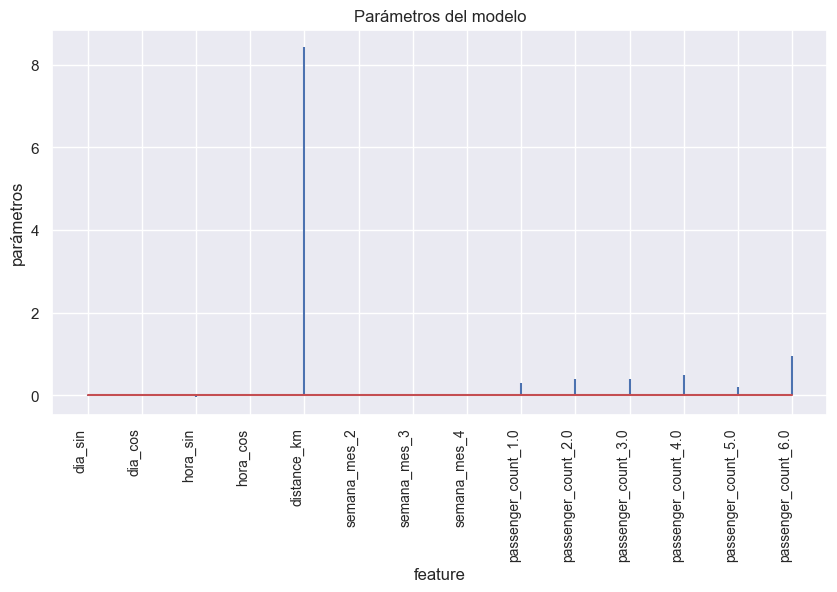

In [153]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

Se seleccionó como métrica de comparación de los modelos la métrica RMSE, ya que permite visualizar la variable en su unidad correspondiente.

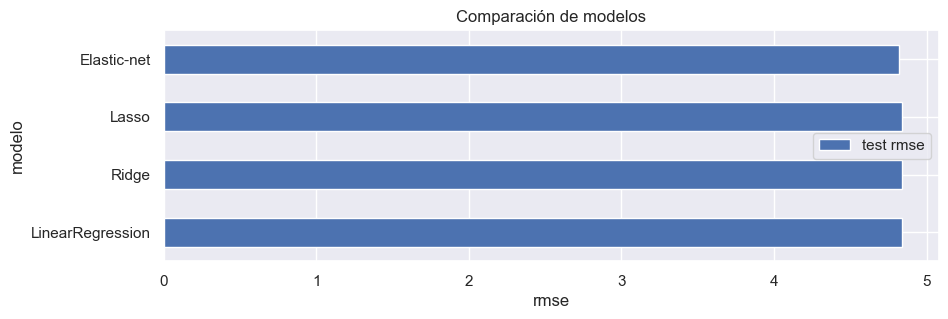

In [154]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse, rmse_ridge, rmse_lasso, rmse_elastic_net]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')
plt.show()

El error de todos los modelos es igual, permitiendo llegar a la conclusión de que todos alcanzaron un mínimo global de los parámetros con respecto a la función de error (que es el mismo que se obtiene haciendo el cálculo de los mínimos cuadrados). También permite descartar indicios de overfitting, ya que, de haber sido el caso, cualquiera de los modelos con restricción de coeficientes hubieran dado un mejor resultado. 
Como conclusión, el modelo considerado más optimo es la regresión lineal, por ser el más simple y el que implica un menor costo computacional.

El modelo generado parece explicar la mayoría de la varianza de los datos, al mismo tiempo que demuestra una capacidad óptima de predecir valores con distancias cuyo rango no escapa de la ciudad de Nueva York. Se intuye que el mismo tendrá problemas para realizar predicciones con viajes particulares con distancias grandes debido a la falta de información correcta en el dataset de este tipo de casos.